In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random 
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))

32033


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim , eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers trained with a running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        #Forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)                 #batch mean
            xvar = x.var(0, keepdim=True, unbiased=True)    #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)    #normalize
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),               generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),  BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1                 #gamma for batchnorm and weight for softmax
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud  = []

for i in range(max_steps):
    #minibatch constuct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.05 if i < 100000 else 0.005
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break   #Debug purpouse


      0/ 200000: 3.2870


layer: 2 (      Tanh): mean -0.00, std: 0.63, saturated: 2.34%
layer: 5 (      Tanh): mean +0.00, std: 0.64, saturated: 2.59%
layer: 8 (      Tanh): mean -0.00, std: 0.64, saturated: 2.25%
layer: 11 (      Tanh): mean +0.00, std: 0.64, saturated: 2.06%
layer: 14 (      Tanh): mean +0.00, std: 0.64, saturated: 2.19%


Text(0.5, 1.0, 'activation distribution')

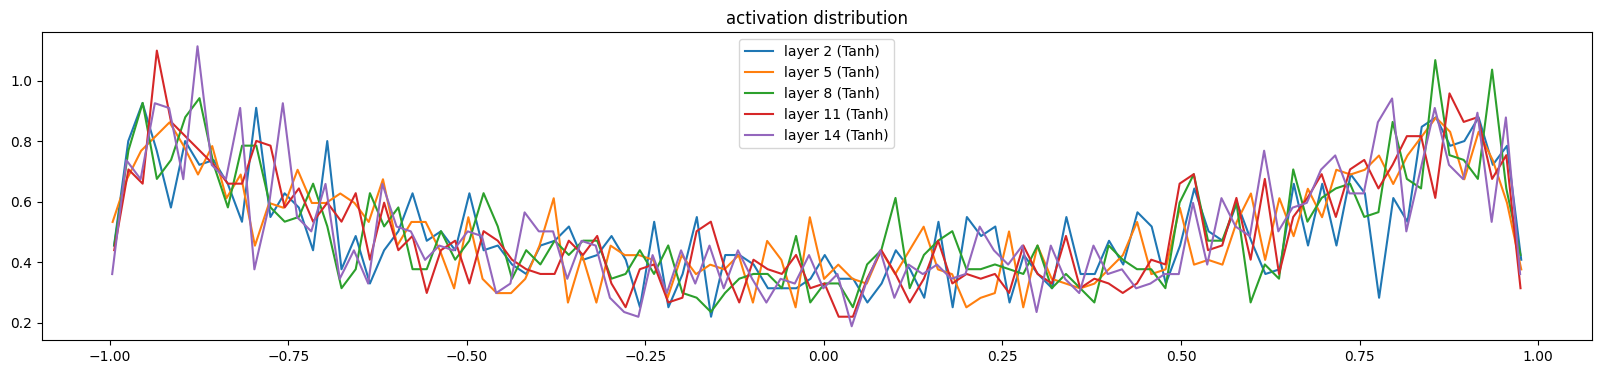

In [7]:
#visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer: %d (%10s): mean %+.2f, std: %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer: 2 (      Tanh): mean +0.000000, std: 4.208409e-03
layer: 5 (      Tanh): mean -0.000000, std: 3.729164e-03
layer: 8 (      Tanh): mean +0.000000, std: 3.403352e-03
layer: 11 (      Tanh): mean -0.000000, std: 3.086197e-03
layer: 14 (      Tanh): mean -0.000000, std: 2.841270e-03


Text(0.5, 1.0, 'activation distribution')

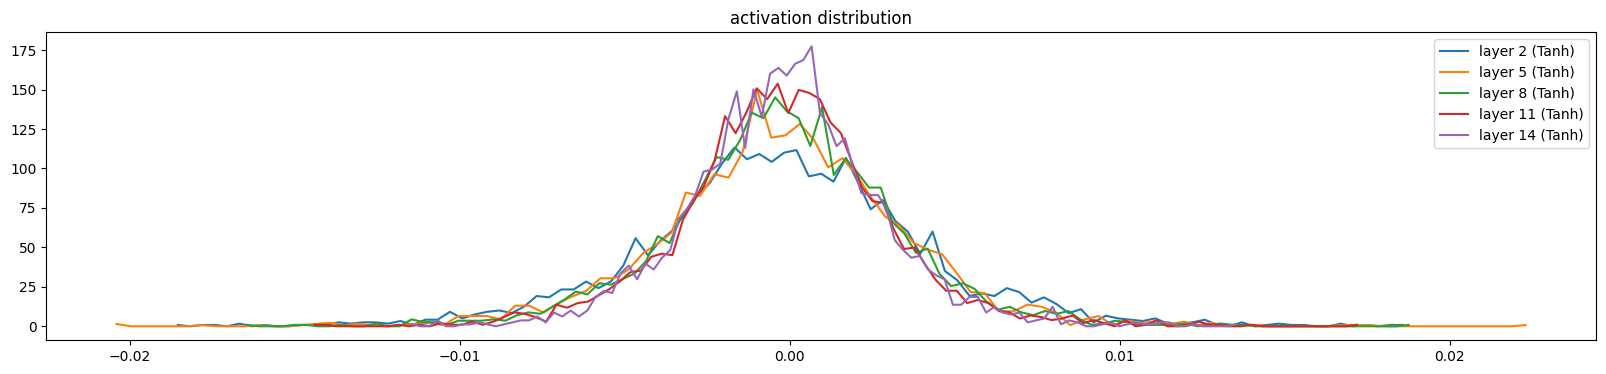

In [8]:
#visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer: %d (%10s): mean %+f, std: %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

weight:   (27, 10) | mean +0.000000 | std 1.076064e-02 | grad:data ratio 1.075218e-02
weight:  (30, 100) | mean +0.000139 | std 9.284132e-03 | grad:data ratio 2.975537e-02
weight: (100, 100) | mean +0.000101 | std 8.491030e-03 | grad:data ratio 5.102931e-02
weight: (100, 100) | mean -0.000068 | std 7.624551e-03 | grad:data ratio 4.536101e-02
weight: (100, 100) | mean +0.000024 | std 6.731209e-03 | grad:data ratio 4.021985e-02
weight: (100, 100) | mean -0.000080 | std 6.230209e-03 | grad:data ratio 3.719889e-02
weight:  (100, 27) | mean -0.000138 | std 1.152663e-02 | grad:data ratio 6.976303e-02


Text(0.5, 1.0, 'weights gradient distribution')

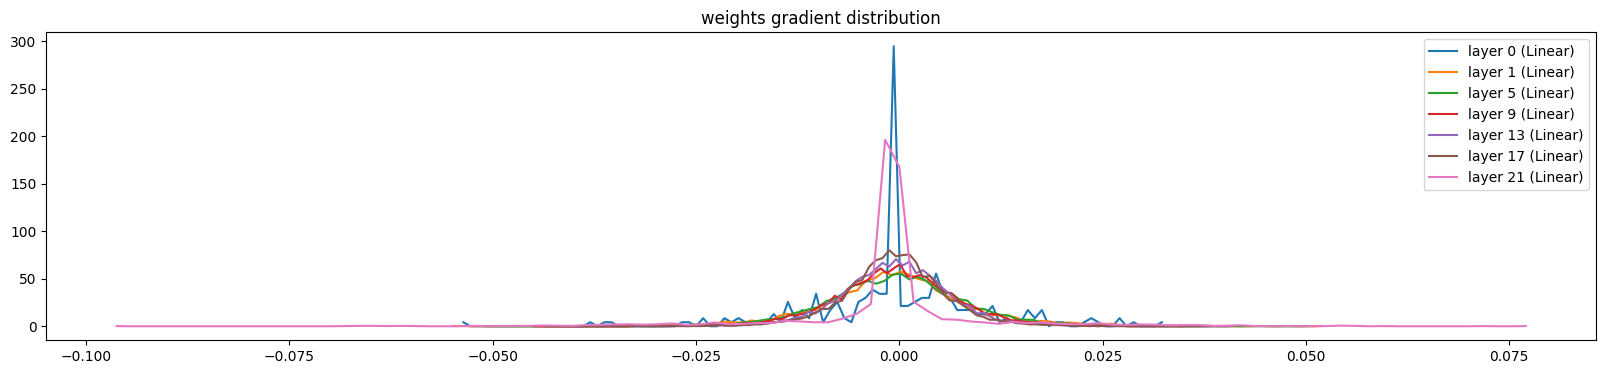

In [9]:
#visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight: %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('weights gradient distribution')

Text(0.5, 1.0, 'weights gradient distribution')

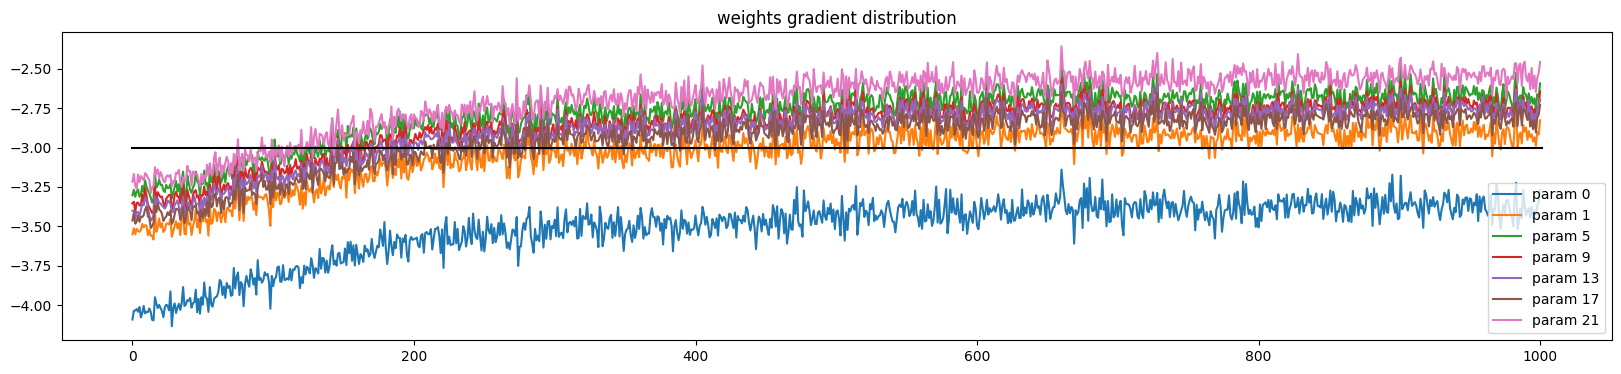

In [10]:
#visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.title('weights gradient distribution')

In [11]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

for layer in layers:
    layer.training = False

split_loss('train')
split_loss('val')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (182625x3 and 30x100)

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmahzadelle.
khyrin.
xith.
cassanden.
jazonte.
deliah.
jareen.
nellara.
chaily.
kaleigh.
ham.
prin.
quint.
shlilah.
jadiq.
wavero.
dearisia.
kaellinsley.
daedo.
abette.
